# Estimating effective population size from nucleotide diversity

### Isabelle Rajendiran

The chosen dataset was An.coluzzii in Niono, Mali from 2013 and 2015.

### 0. Importing packages

In [1]:
# INSTALLING AND IMPORTING PACKAGES

#!pip install -q malariagen_data
#!pip install ipyleaflet

import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
from dask.diagnostics.progress import ProgressBar
# silence some warnings
dask.config.set(**{'array.slicing.split_large_chunks': False})
import allel; print('scikit-allel', allel.__version__)
import malariagen_data
import pandas as pd
import pickle 

scikit-allel 1.3.5


In [2]:
# IMPORT API
# AG3 DATA ACCESS FROM GOOGLE CLOUD

ag3 = malariagen_data.Ag3(pre='True') # Pre=True is needed to include data from all data beyond 3.0 release/phase (3.0-3.8)
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8
Results cache           : None
Cohorts analysis        : 20230223
Species analysis        : aim_20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 7.3.1
Client location         : England, GB
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/vector-data/ag3/api.html

### 1. Computing diversity statistics

The aim here is to calculate diversity statisitics (nucleotide diversity) for the desired sample (Niono, Mali for coluzzii between 2013 and 2015).

Different parameters are tested (3R vs X chromosome, intergenic vs 4-fold degenerate) to see their impact.

NOTE: Uses the diversity_stats() function means we cannot specify biallelic (but this is not necessary).

#### 1.1 Identifying cohorts to use

In [ ]:
# IDENTIFYING THE PRE-DEFINED COHORTS TO USE

# Load the metadata for Mali
Mali_metadata = ag3.sample_metadata(sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                   sample_query = "country == 'Mali' ")

Mali_metadata #1030 rows

# Display all rows
pd.set_option('display.max_rows', None)

# Display the columns in the metadata
print(Mali_metadata.columns)

# Group the samples by their 'cohort_admin2_year' column
Mali_metadata.groupby(['cohort_admin2_year']).size()

From this list, the cohorts we want are 'ML-4_Niono_colu_2015' and 'ML-4_Niono_colu_2013'

NOTE: These cohorts use different granularity in location. For example., "cohort_admin2_year” groups samples by administrative level 2 divisions (usually called districts) and the year of sample collection. To specify our own granularity in location, we need to make our own cohorts.

#### 1.2 Computing diversity statistics

ag3.diveristy_stats() allows you to specify the sample_sets and sample_query to use as well as other parameters.

The cohort_size used needs to be the same for both cohorts to allow a fair comparision of nucleotide diversity. 70 was chosen here as it is the highest (rounded down) amount for the cohort with the lowest amount of samples (73 for 2013).

In [ ]:
# COMPUTING DIVERSITY STATISTICS 
# 3R and 4-fold degenerate sites

Mali_Niono_dv_stats_3R_4 = ag3.diversity_stats(
    sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
    sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')",
    cohorts="admin2_year",
    cohort_size=70,
    region="3R",
    site_mask="gamb_colu",
    site_class="CDS_DEG_4",
)

Mali_Niono_dv_stats_3R_4

In [ ]:
# PLOTTING THE NUCLEOTIDE DIVERSITY 
# Uses plotly_express

# Change the 'year' column type to category
Mali_Niono_dv_stats_3R_4["year"] = Mali_Niono_dv_stats_3R_4["year"].astype("category") # Needed for the plot's legend to have discrete years

# Plot as bar plot
px.bar(
    data_frame=Mali_Niono_dv_stats_3R_4, 
    color="year",
    x="cohort",
    y="theta_pi_estimate",
    error_y="theta_pi_ci_err",
    height=450,
    width=500,
    title = "3R and 4-fold degenerate sites"
)

In [ ]:
# COMPUTING DIVERSITY STATISTICS 
# X and 4-fold degenerate sites

Mali_Niono_dv_stats_X_4 = ag3.diversity_stats(
    sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
    sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')",
    cohorts="admin2_year",
    cohort_size=70,
    region="X",
    site_mask="gamb_colu",
    site_class="CDS_DEG_4",
)

Mali_Niono_dv_stats_X_4

In [ ]:
# PLOTTING THE NUCLEOTIDE DIVERSITY 

# Change the 'year' column type to category
Mali_Niono_dv_stats_X_4["year"] = Mali_Niono_dv_stats_X_4["year"].astype("category")

# Plot as bar plot
px.bar(
    data_frame=Mali_Niono_dv_stats_X_4, 
    color="year",
    x="cohort",
    y="theta_pi_estimate",
    error_y="theta_pi_ci_err",
    height=450,
    width=500,
    title = "X and 4-fold degenerate sites"
)


In [ ]:
# COMPUTING DIVERSITY STATISTICS 
# 3R and intergenic sites

Mali_Niono_dv_stats_3R_int = ag3.diversity_stats(
    sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
    sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')",
    cohorts="admin2_year",
    cohort_size=70,
    region="3R",
    site_mask="gamb_colu",
    site_class="INTERGENIC",
)

Mali_Niono_dv_stats_3R_int

In [ ]:
# PLOTTING THE NUCLEOTIDE DIVERSITY 

# Change the 'year' column type to category
Mali_Niono_dv_stats_3R_int["year"] = Mali_Niono_dv_stats_3R_int["year"].astype("category")

# Plot as bar plot
px.bar(
    data_frame=Mali_Niono_dv_stats_3R_int, 
    color="year",
    x="cohort",
    y="theta_pi_estimate",
    error_y="theta_pi_ci_err",
    height=450,
    width=500,
    title = "3R and intergenic sites"
)


In [ ]:
# COMPUTING DIVERSITY STATISTICS 
# X and intergenic sites

Mali_Niono_dv_stats_X_int = ag3.diversity_stats(
    sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
    sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')",
    cohorts="admin2_year",
    cohort_size=70,
    region="X",
    site_mask="gamb_colu",
    site_class="INTERGENIC",
)

Mali_Niono_dv_stats_X_int

In [ ]:
# PLOTTING THE NUCLEOTIDE DIVERSITY 

# Change the 'year' column type to category
Mali_Niono_dv_stats_X_int["year"] = Mali_Niono_dv_stats_X_int["year"].astype("category")

# Plot as bar plot
px.bar(
    data_frame=Mali_Niono_dv_stats_X_int, 
    color="year",
    x="cohort",
    y="theta_pi_estimate",
    error_y="theta_pi_ci_err",
    height=450,
    width=500,
    title = "X and intergenic sites"
)


#### 1.3 Calculating the number of sites used

Also in the notebook labelled 'FYP - (2.1) Diversity number of sites'

Given that the diversity_stats() function requires the region to be specified, you can use snp_calls() to count the number of SNPs in that region to get the number of sites that were used. This can be used to count the number of polymorphic sites too.

In [ ]:
# COUNTING THE NUMBER OF SITES USED TO COMPUTE THE DIVERSITY STATISTICS

# Conducting snp_calls for the desired samples
snps_X_4_2013 = ag3.snp_calls(cohort_size=70, region= "X", site_mask="gamb_colu", site_class="CDS_DEG_4", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013) and (location == 'Sokourani (Niono)')")
snps_3R_4_2013 = ag3.snp_calls(cohort_size=70,region= "3R", site_mask="gamb_colu", site_class="CDS_DEG_4", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013) and (location == 'Sokourani (Niono)')")
snps_X_int_2013 = ag3.snp_calls(cohort_size=70,region= "X", site_mask="gamb_colu", site_class="INTERGENIC", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013) and (location == 'Sokourani (Niono)')")
snps_3R_int_2013 = ag3.snp_calls(cohort_size=70, region= "3R", site_mask="gamb_colu", site_class="INTERGENIC", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013) and (location == 'Sokourani (Niono)')")

snps_X_4_2015 = ag3.snp_calls(cohort_size=70, region= "X", site_mask="gamb_colu", site_class="CDS_DEG_4", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2015) and (location == 'Sokourani (Niono)')")
snps_3R_4_2015 = ag3.snp_calls(cohort_size=70,region= "3R", site_mask="gamb_colu", site_class="CDS_DEG_4", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2015) and (location == 'Sokourani (Niono)')")
snps_X_int_2015 = ag3.snp_calls(cohort_size=70,region= "X", site_mask="gamb_colu", site_class="INTERGENIC", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2015) and (location == 'Sokourani (Niono)')")
snps_3R_int_2015 = ag3.snp_calls(cohort_size=70, region= "3R", site_mask="gamb_colu", site_class="INTERGENIC", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2015) and (location == 'Sokourani (Niono)')")

In [ ]:
# Computing genotype calls with the SNP datasets
snps_X_4_2013_gt = allel.GenotypeDaskArray(snps_X_4_2013["call_genotype"].data)
snps_3R_4_2013_gt = allel.GenotypeDaskArray(snps_3R_4_2013["call_genotype"].data)
snps_X_int_2013_gt = allel.GenotypeDaskArray(snps_X_int_2013["call_genotype"].data)
snps_3R_int_2013_gt = allel.GenotypeDaskArray(snps_3R_int_2013["call_genotype"].data)

snps_X_4_2015_gt = allel.GenotypeDaskArray(snps_X_4_2015["call_genotype"].data)
snps_3R_4_2015_gt = allel.GenotypeDaskArray(snps_3R_4_2015["call_genotype"].data)
snps_X_int_2015_gt = allel.GenotypeDaskArray(snps_X_int_2015["call_genotype"].data)
snps_3R_int_2015_gt = allel.GenotypeDaskArray(snps_3R_int_2015["call_genotype"].data)b

In [9]:
# REMOVE MISSING GENOTYPES

def remove_missing(snps, gt):
    # Create a 2D boolean array where TRUE indicates missing genotypes 
    missing = gt.is_missing() 
    # Create a 1D boolean array where it is TRUE if any of the genotypes per row is TRUE i.e., missing genotype for even 1 indivdual
    missing = np.any(missing, axis=1)
    mask = missing.compute()
    # Create an index array of the variant positions with no missing genotypes
    index = np.where(mask==False)[0] 
    # Subset the snp dataset to only contain non-missing sites
    new_snps = snps.isel(variants=index)
    return new_snps


In [ ]:
# Filter the snps for non-missing snps only
snps_X_4_2013_no_nan = remove_missing(snps_X_4_2013, snps_X_4_2013_gt)
snps_X_int_2013_no_nan = remove_missing(snps_X_int_2013, snps_X_int_2013_gt)
snps_3R_4_2013_no_nan = remove_missing(snps_3R_4_2013, snps_3R_4_2013_gt)
snps_3R_int_2013_no_nan = remove_missing(snps_3R_int_2013, snps_3R_int_2013_gt)

snps_X_4_2015_no_nan = remove_missing(snps_X_4_2015, snps_X_4_2015_gt)
snps_X_int_2015_no_nan = remove_missing(snps_X_int_2015, snps_X_int_2015_gt)
snps_3R_4_2015_no_nan = remove_missing(snps_3R_4_2015, snps_3R_4_2015_gt)
snps_3R_int_2015_no_nan = remove_missing(snps_3R_int_2015, snps_3R_int_2015_gt)

In [ ]:
# EXPORT THE DATASETS USING AS .PKL

with open('snps_X_4_2013_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_X_4_2013_no_nan, f)

with open('snps_X_int_2013_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_X_int_2013_no_nan, f)
    
with open('snps_3R_4_2013_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_3R_4_2013_no_nan, f)

with open('snps_3R_int_2013_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_3R_int_2013_no_nan, f)
    
    
with open('snps_X_4_2015_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_X_4_2015_no_nan, f)

with open('snps_X_int_2015_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_X_int_2015_no_nan, f)
    
with open('snps_3R_4_2015_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_3R_4_2015_no_nan, f)

with open('snps_3R_int_2015_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_3R_int_2015_no_nan, f)

In [ ]:
# RE-COMPUTE GENOTYPE CALLS

snps_X_4_2013_no_nan_gt = allel.GenotypeDaskArray(snps_X_4_2013_no_nan["call_genotype"].data)
snps_X_int_2013_no_nan_gt = allel.GenotypeDaskArray(snps_X_int_2013_no_nan["call_genotype"].data)
snps_3R_4_2013_no_nan_gt = allel.GenotypeDaskArray(snps_3R_4_2013_no_nan["call_genotype"].data)
snps_3R_int_2013_no_nan_gt = allel.GenotypeDaskArray(snps_3R_int_2013_no_nan["call_genotype"].data)

snps_X_4_2015_no_nan_gt = allel.GenotypeDaskArray(snps_X_4_2015_no_nan["call_genotype"].data)
snps_X_int_2015_no_nan_gt = allel.GenotypeDaskArray(snps_X_int_2015_no_nan["call_genotype"].data)
snps_3R_4_2015_no_nan_gt = allel.GenotypeDaskArray(snps_3R_4_2015_no_nan["call_genotype"].data)
snps_3R_int_2015_no_nan_gt = allel.GenotypeDaskArray(snps_3R_int_2015_no_nan["call_genotype"].data)

In [ ]:
# COMPUTE ALLELE COUNTS

snps_X_4_2013_no_nan_ac = snps_X_4_2013_no_nan_gt.count_alleles(max_allele=3).compute()
snps_X_int_2013_no_nan_ac = snps_X_int_2013_no_nan_gt.count_alleles(max_allele=3).compute()
snps_3R_4_2013_no_nan_ac = snps_3R_4_2013_no_nan_gt.count_alleles(max_allele=3).compute()
snps_3R_int_2013_no_nan_ac = snps_3R_int_2013_no_nan_gt.count_alleles(max_allele=3).compute()

snps_X_4_2015_no_nan_ac = snps_X_4_2015_no_nan_gt.count_alleles(max_allele=3).compute()
snps_X_int_2015_no_nan_ac = snps_X_int_2015_no_nan_gt.count_alleles(max_allele=3).compute()
snps_3R_4_2015_no_nan_ac = snps_3R_4_2015_no_nan_gt.count_alleles(max_allele=3).compute()
snps_3R_int_2015_no_nan_ac = snps_3R_int_2015_no_nan_gt.count_alleles(max_allele=3).compute()

In [ ]:
# COUNT THE NUMBER OF VARIANTS (BIALLELIC, MULTIALLELIC AND FIXED)

print("Number of variants 2013 (X_4):", len(snps_X_4_2013_no_nan)) # Total number of sites
print("Number of fixed sites 2013 (X_4):", np.count_nonzero(~snps_X_4_2013_no_nan_ac.is_variant())) #~ needed to count where it is false
print("Number of segregating SNPs 2013 (X_4):", (snps_X_4_2013_no_nan_ac.is_segregating().sum()))
print("Number of biallelic SNPs 2013 (X_4):", snps_X_4_2013_no_nan_ac.is_biallelic().sum())
print("Number of multiallelic SNPs 2013 (X_4):", (snps_X_4_2013_no_nan_ac.is_segregating().sum()- snps_X_4_2013_no_nan_ac.is_biallelic().sum()))
# Biallelic + multiallelic should = segregating

print("\nNumber of variants 2015 (X_4):", len(snps_X_4_2015_no_nan))
print("Number of fixed sites 2015 (X_4):", np.count_nonzero(~snps_X_4_2015_no_nan_ac.is_variant()))
print("Number of segregating SNPs 2015 (X_4):", (snps_X_4_2015_no_nan_ac.is_segregating().sum()))
print("Number of biallelic SNPs 2015 (X_4):", snps_X_4_2015_no_nan_ac.is_biallelic().sum())
print("Number of multiallelic SNPs 2015 (X_4):", (snps_X_4_2015_no_nan_ac.is_segregating().sum()- snps_X_4_2015_no_nan_ac.is_biallelic().sum()))

print("\nNumber of variants 2013 (X_int):", len(snps_X_int_2013_no_nan))
print("Number of fixed sites 2013 (X_int):", np.count_nonzero(~snps_X_int_2013_no_nan_ac.is_variant()))
print("Number of segregating SNPs 2013 (X_int):", (snps_X_int_2013_no_nan_ac.is_segregating().sum()))
print("Number of biallelic SNPs 2013 (X_int):", snps_X_int_2013_no_nan_ac.is_biallelic().sum())
print("Number of multiallelic SNPs 2013 (X_int):", (snps_X_int_2013_no_nan_ac.is_segregating().sum()- snps_X_int_2013_no_nan_ac.is_biallelic().sum()))


print("\nNumber of variants 2015 (X_int):", len(snps_X_int_2015_no_nan))
print("Number of fixed sites 2015 (X_int):", np.count_nonzero(~snps_X_int_2015_no_nan_ac.is_variant()))
print("Number of segregating SNPs 2015 (X_int):", (snps_X_int_2015_no_nan_ac.is_segregating().sum()))
print("Number of biallelic SNPs 2015 (X_int):", snps_X_int_2015_no_nan_ac.is_biallelic().sum())
print("Number of multiallelic SNPs 2015 (X_int):", (snps_X_int_2015_no_nan_ac.is_segregating().sum()- snps_X_int_2015_no_nan_ac.is_biallelic().sum()))

print("\nNumber of variants 2013 (3R_4):", len(snps_3R_4_2013_no_nan))
print("Number of fixed sites 2013 (3R_4):", np.count_nonzero(~snps_3R_4_2013_no_nan_ac.is_variant()))
print("Number of segregating SNPs 2013 (3R_4):", (snps_3R_4_2013_no_nan_ac.is_segregating().sum()))
print("Number of biallelic SNPs 2013 (3R_4):", snps_3R_4_2013_no_nan_ac.is_biallelic().sum())
print("Number of multiallelic SNPs 2013 (3R_4):", (snps_3R_4_2013_no_nan_ac.is_segregating().sum()- snps_3R_4_2013_no_nan_ac.is_biallelic().sum()))

print("\nNumber of variants 2015 (3R_4):", len(snps_3R_4_2015_no_nan))
print("Number of fixed sites 2015 (3R_4):", np.count_nonzero(~snps_3R_4_2015_no_nan_ac.is_variant()))
print("Number of segregating SNPs 2015 (3R_4):", (snps_3R_4_2015_no_nan_ac.is_segregating().sum()))
print("Number of biallelic SNPs 2015 (3R_4):", snps_3R_4_2015_no_nan_ac.is_biallelic().sum())
print("Number of multiallelic SNPs 2015 (3R_4):", (snps_3R_4_2015_no_nan_ac.is_segregating().sum()- snps_3R_4_2015_no_nan_ac.is_biallelic().sum()))

print("\nNumber of variants 2013 (3R_int):", len(snps_3R_int_2013_no_nan))
print("Number of fixed sites 2013 (3R_int):", np.count_nonzero(~snps_3R_int_2013_no_nan_ac.is_variant()))
print("Number of segregating SNPs 2013 (3R_int):", (snps_3R_int_2013_no_nan_ac.is_segregating().sum()))
print("Number of biallelic SNPs 2013 (3R_int):", snps_3R_int_2013_no_nan_ac.is_biallelic().sum())
print("Number of multiallelic SNPs 2013 (3R_int):", (snps_3R_int_2013_no_nan_ac.is_segregating().sum()- snps_3R_int_2013_no_nan_ac.is_biallelic().sum()))

print("\nNumber of variants 2015 (3R_int):", len(snps_3R_int_2015_no_nan))
print("Number of fixed sites 2015 (3R_int):", np.count_nonzero(~snps_3R_int_2015_no_nan_ac.is_variant()))
print("Number of segregating SNPs 2015 (3R_int):", (snps_3R_int_2015_no_nan_ac.is_segregating().sum()))
print("Number of biallelic SNPs 2015 (3R_int):", snps_3R_int_2015_no_nan_ac.is_biallelic().sum())
print("Number of multiallelic SNPs 2015 (3R_int):", (snps_3R_int_2015_no_nan_ac.is_segregating().sum()- snps_3R_int_2015_no_nan_ac.is_biallelic().sum()))

#### 1.4 Estimating expected nucleotide diversity

A diploid male mosquito will have 2 pairs of autosomes (2 pairs of chromosomes 3 and 2) and a pair of sex chromosomes (XY). A female will also have 2 pairs of autosomes and a pair of sex chromosomes (XX). 

In total, between a male and female, they will have 4 chromosomes 3 (and 2), 3 X chromosomes and 1 Y chromosomes. Therefore, the X chromosome will only contain 3/4 genetic diversity of chromosome 3 (and 2). This is the expectation roughly. 

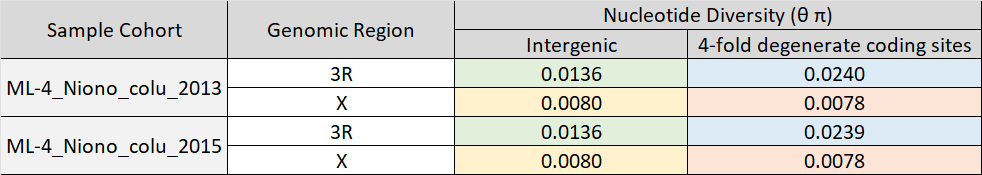

Results:
- Very similar genetic diversity between 2013 and 2015 for all equivalent comparisons e.g., 3R intergenic for 2013 vs 2015
- For the same chromosome, the 4-fold diversity is much lower than intergenic - need to investigate why
- For the same type of sites (e.g., intergenic), the X chromosome has a lower genetic diversity than 3R - is this similar to expected? Need to investigate furthur.

In [ ]:
# ESTIMATING THE EXPECTED GENETIC DIVERSITY FOR X CHROMOSOME

# NOTE: This assumes the nucleotide diversity for the 3R is accurate

# Calculating 3/4 of the diversity for 3R for the intergenic results
print("Intergenic expected:", format(0.0136*0.75, '.4f'))
print("Intergenic actual: 0.0080 \n")

# Calculating 3/4 of the diversity for 3R for the 4-fold results
print("4-fold expected:", format(0.0240*0.75, '.4f'))
print("4-fold actual: 0.0078")


In [6]:
# X/3R RATIO

print(format(0.0080/0.0136, '.2f'))
print(format(0.0078/0.0240, '.2f'))
print(format(0.0078/0.0239, '.2f'))

0.59
0.32
0.33


The actual values are lower than expected (lower diversity) but seem to match the Extended Data Figure 3 from the Phase 1 paper (Genetic diversity of the African malaria vector Anopheles gambiae)  


<div>
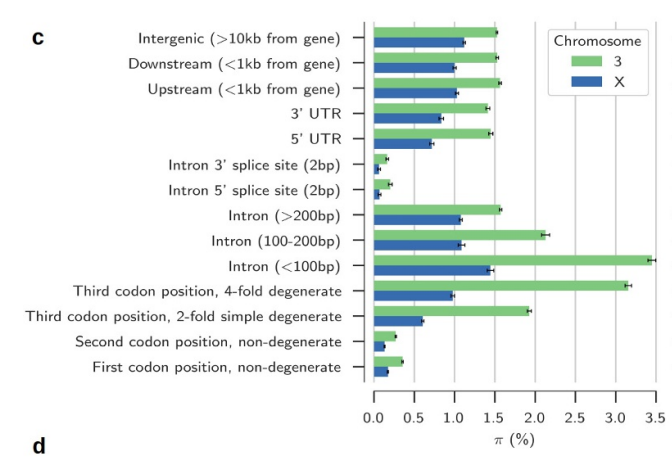
</div>



For 4-fold, pi for X is 0.01, and 0.032 for chrom 3.

For intergenic, pi for X is 0.011, and 0.015 for chrom 3.

### 2. Investigating the nucleotide diversity results

Recombination, the number of genes used etc could be a reason for lowered diversity.

#### 2.1 Gene Density

Comparing the number of genes in the 3R and X chromosome and spread of genes

In [59]:
# PLOTTING THE GENES FOUND ON CHROMOSOME 3R

ag3.plot_genes(region = "3R", title='Genes in chromosome 3R')

Figure(id='1099', ...)

3R is roughly 53 Mbp long and had a roughly even distribution of genes

In [60]:
# lOADING ALL THE GENES FOUND ON 3R

genes_3R = ag3.geneset(region = "3R")
#display(genes_3R)

# Count the number of genes
len(genes_3R) #41,330 genes

41330

In [61]:
# REPEAT FOR CHROMOSOME X

# Plot the genes
ag3.plot_genes(region = "X", title='Genes in chromosome X')

Figure(id='1200', ...)

In [ ]:
# lOADING ALL THE GENES FOUND ON X

genes_X = ag3.geneset(region = "X")
#display(genes_X)

# Count the number of genes
len(genes_X) #17,498 genes

Chromosome X has less than half the number of genes (17,498) than found on chromosome 3R (41,330).

In [1]:
41330/17498

2.3619842267687736

In [ ]:
# PLOTTING A BAR CHART

# Creating a dataframe with the number of genes in each chromosome
df_genes = pd.DataFrame({'Chromosome':['3R', 'X'], 'Number of Genes':[41330,17498]})
df_genes 

# Plotting and viewing a bar chart
fig = px.bar(df_genes, x='Chromosome', y='Number of Genes',
             height=400, width = 400)

fig.show()

### 3. Sliding Window Analysis of Nucleotide Diversity

We want to investigate the heterogeniety of nucleotide diversity across the chromosomes. For the sliding window analysis, the 2013 and 2015 cohorts have been combined as no differences were observed in diversity previously and all individuals used.

#### 3.1 Filtering the SNP datasets

In [6]:
# CONDUCT SNP CALLS

snps_X_4 = ag3.snp_calls(region= "X", site_mask="gamb_colu", site_class="CDS_DEG_4", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')")
snps_3R_4 = ag3.snp_calls(region= "3R", site_mask="gamb_colu", site_class="CDS_DEG_4", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')")
snps_X_int = ag3.snp_calls(region= "X", site_mask="gamb_colu", site_class="INTERGENIC", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')")
snps_3R_int = ag3.snp_calls(region= "3R", site_mask="gamb_colu", site_class="INTERGENIC", sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')")

Locate CDS_DEG_4 sites:   0%|          | 0/7 [00:00<?, ?it/s]

Load sample metadata:   0%|          | 0/69 [00:00<?, ?it/s]

Locate CDS_DEG_4 sites:   0%|          | 0/7 [00:00<?, ?it/s]

Locate INTERGENIC sites:   0%|          | 0/7 [00:00<?, ?it/s]

Locate INTERGENIC sites:   0%|          | 0/22 [00:00<?, ?it/s]

In [10]:
# CONDUCT GENOTYPE CALLS

snps_X_4_gt = allel.GenotypeDaskArray(snps_X_4["call_genotype"].data)
snps_3R_4_gt = allel.GenotypeDaskArray(snps_3R_4["call_genotype"].data)
snps_X_int_gt = allel.GenotypeDaskArray(snps_X_int["call_genotype"].data)
snps_3R_int_gt = allel.GenotypeDaskArray(snps_3R_int["call_genotype"].data)

In [11]:
# FILTER OUT MISSING SITES

snps_X_4_no_nan = remove_missing(snps_X_4, snps_X_4_gt)
snps_X_int_no_nan = remove_missing(snps_X_int, snps_X_int_gt)
snps_3R_4_no_nan = remove_missing(snps_3R_4, snps_3R_4_gt)
snps_3R_int_no_nan = remove_missing(snps_3R_int, snps_3R_int_gt)

In [12]:
# DISPLAY THE NUMBER OF SNPS IN EACH

# Includes missing sites
print("X_4-fold:", len(snps_X_4.variants))
print("3R_4-fold:",len(snps_3R_4.variants))
print("X_Intergenic:",len(snps_X_int.variants))
print("3R_Intergenic:",len(snps_3R_int.variants))

# Removed missing sites
print("\nX_4-fold:", len(snps_X_4_no_nan.variants))
print("3R_4-fold:",len(snps_3R_4_no_nan.variants))
print("X_Intergenic:",len(snps_X_int_no_nan.variants))
print("3R_Intergenic:",len(snps_3R_int_no_nan.variants))

X_4-fold: 250882
3R_4-fold: 570337
X_Intergenic: 4107233
3R_Intergenic: 10896152

X_4-fold: 248337
3R_4-fold: 562322
X_Intergenic: 3658888
3R_Intergenic: 9588535


Results:

- X_4-fold: 250882
- 3R_4-fold: 570337
- X_Intergenic: 4107233
- 3R_Intergenic: 10896152

After removing missing sites:
- X_4-fold: 248337
- 3R_4-fold: 562322
- X_Intergenic: 3658888
- 3R_Intergenic: 9588535

In [13]:
# EXPORTING THE DATASETS USING PICKLE

with open('snps_3R_int_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_3R_int_no_nan, f)

with open('snps_3R_4_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_3R_4_no_nan, f)
    
with open('snps_X_int_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_X_int_no_nan, f)

with open('snps_X_4_no_nan.pkl', 'wb') as f:
    pickle.dump(snps_X_4_no_nan, f)

In [ ]:
# IMPORTING THE DATASETS USING PICKLE 

with open('snps_X_4_no_nan.pkl', 'rb') as f:
    snps_X_4_no_nan = pickle.load(f)

with open('snps_X_int_no_nan.pkl', 'rb') as f:
    snps_X_int_no_nan = pickle.load(f)
    
with open('snps_3R_4_no_nan.pkl', 'rb') as f:
    snps_X_int_no_nan = pickle.load(f)

with open('snps_3R_4_no_nan.pkl', 'rb') as f:
    snps_X_4_no_nan = pickle.load(f)
    

In [14]:
# RE-COMPUTE GENOTYPE CALLS

snps_X_4_no_nan_gt = allel.GenotypeDaskArray(snps_X_4_no_nan["call_genotype"].data)
snps_3R_4_no_nan_gt = allel.GenotypeDaskArray(snps_3R_4_no_nan["call_genotype"].data)
snps_X_int_no_nan_gt = allel.GenotypeDaskArray(snps_X_int_no_nan["call_genotype"].data)
snps_3R_int_no_nan_gt = allel.GenotypeDaskArray(snps_3R_int_no_nan["call_genotype"].data)

In [15]:
# COMPUTE ALLELE COUNTS
snps_X_4_no_nan_ac = snps_X_4_no_nan_gt.count_alleles(max_allele=3).compute()
snps_3R_4_no_nan_ac = snps_3R_4_no_nan_gt.count_alleles(max_allele=3).compute()
snps_X_int_no_nan_ac = snps_X_int_no_nan_gt.count_alleles(max_allele=3).compute()
snps_3R_int_no_nan_ac = snps_3R_int_no_nan_gt.count_alleles(max_allele=3).compute()

#### 3.2 Compute the p and q allele frequencies

In [16]:
# RE-COMPUTE ALLELE FREQUENCIES 

snps_X_4_no_nan_freq = snps_X_4_no_nan_ac.to_frequencies()
snps_X_int_no_nan_freq = snps_X_int_no_nan_ac.to_frequencies()
snps_3R_4_no_nan_freq = snps_3R_4_no_nan_ac.to_frequencies()
snps_3R_int_no_nan_freq = snps_3R_int_no_nan_ac.to_frequencies()

In [17]:
# CALCULATE THE MAJOR (p) AND ALTERNATE (q) ALLELE FREQUENCY 

def p_q_allele_frequencies(allele_freq):
    # Create empty vectors to store the frequencies
    major_allele_freq = []
    alternate_allele_freq = []
    
    # Loop through the sites and append the major and grouped alternate alleles to the vector
    for snp in allele_freq:
        major_allele_freq.append(max(snp))
        alternate_allele_freq.append(1 - max(snp))
    
    # Retun the vectors
    return major_allele_freq, alternate_allele_freq


major_allele_freq_X_4, alternate_allele_freq_X_4 = p_q_allele_frequencies(snps_X_4_no_nan_freq)
major_allele_freq_X_int, alternate_allele_freq_X_int = p_q_allele_frequencies(snps_X_int_no_nan_freq)
major_allele_freq_3R_4, alternate_allele_freq_3R_4 = p_q_allele_frequencies(snps_3R_4_no_nan_freq)
major_allele_freq_3R_int, alternate_allele_freq_3R_int = p_q_allele_frequencies(snps_3R_int_no_nan_freq)  

#### 3.3 Calculate average nucleotide diversity for the samples

Note: This will not be identical to the ag3.diversity_stats(). One reason might be because it uses all samples combined from 2013, 2015 and (73 + 104 samples).

In [18]:
# Calculate nucleotide diversity 

def nucleotide_diversity(major, alt):
    # Create a total starting at 0
    total = 0
    # Loop through all the sites
    for i in range(len(major)):
        # Calculate diversity
        total += (2*major[i]*alt[i])
    pi = total/len(major)
    print(pi)
    # Return the diversity value
    return pi


nucleotide_diversity(major_allele_freq_X_int, alternate_allele_freq_X_int)   
nucleotide_diversity(major_allele_freq_X_4, alternate_allele_freq_X_4)  
nucleotide_diversity(major_allele_freq_3R_int, alternate_allele_freq_3R_int)  
nucleotide_diversity(major_allele_freq_3R_4, alternate_allele_freq_3R_4)  

# Relatively similar to the diversity calculated using diversity_stats()

0.0074683398784855855
0.007750611939912194
0.01286800312033295
0.02364575041193739


0.02364575041193739

#### 3.4 Conduct the sliding window analyses

In [19]:
# SLIDING WINDOW ANALYSIS OF PI

def sliding_diversity(snp, major, alt, window_size):
    pi = []
    window_start_pos = []
    actual_window_size = []
    
    # List of the start and stop positions for the window
    window_start = [i for i in range(0, len(snp.variants), window_size)]
    window_stop = [i for i in range(window_size, (len(snp.variants) + window_size), window_size)]    
    
    # Loop through the number of windows in total
    for i in range(0, len(window_start)):
        total = 0
        pi_window = 0
        size_counter = 0
        # Loop through the sites in each window 
        for x in range(window_start[i],window_stop[i]):
            if x == len(snp.variants):
                break  # Breaks loop when reached to the end of the sites (last window will have less sites than window size)
            total += (2 * major[x] * alt[x]) 
            size_counter += 1 # Count number of sites in each window
        pi_window = total/size_counter  
        pi.append(pi_window)
        actual_window_size.append(size_counter)
        
    for start in window_start:
        window_start_pos.append(snp.variant_position.values[start])
        
    return pi, window_start_pos, actual_window_size

In [22]:
pi_X_4, window_X_4, window_size_X_4 = sliding_diversity(snps_X_4_no_nan, major_allele_freq_X_4 , alternate_allele_freq_X_4, 10000)

In [25]:
pi_X_int, window_X_int, window_size_X_int = sliding_diversity(snps_X_int_no_nan, major_allele_freq_X_int , alternate_allele_freq_X_int, 10000)

In [26]:
pi_3R_4, window_3R_4, window_size_3R_4 = sliding_diversity(snps_3R_4_no_nan, major_allele_freq_3R_4 , alternate_allele_freq_3R_4, 10000)

In [43]:
pi_3R_int, window_3R_int, window_size_3R_int = sliding_diversity(snps_3R_int_no_nan, major_allele_freq_3R_int , alternate_allele_freq_3R_int, 10000)

Calculating over 10,000 loci! Maybe do 1000 loci

In [40]:
print(window_3R_4)

[13825, 524696, 1230654, 1536099, 2410001, 2755706, 2934298, 3436811, 4192644, 5067162, 5819567, 6238136, 6569560, 7570021, 8724346, 9727176, 10232011, 10620304, 11117538, 11880609, 13256527, 13802929, 14890682, 16158926, 17389345, 18390344, 19808252, 20591145, 21318962, 22709039, 23763900, 24934956, 25600331, 27496098, 28574183, 29090906, 30665231, 31536787, 33488545, 34734153, 35618202, 36118237, 36940298, 37499998, 38990695, 42364868, 43510495, 44109501, 45215857, 46659283, 47374296, 48065698, 48670566, 49618318, 50615738, 51647736, 52303428]


In [44]:
# EXPORT POSITIONS FOR 3R_4 AS CSV
#np.savetxt("3R_4 positions.csv", snps_3R_4_no_nan.variant_position.values, delimiter=",")

In [ ]:
# EXPORT - LONG VERSION IN CASE THE OTHER DOES NOT WORK

#with open('pi_X_4.pkl', 'wb') as f:
#    pickle.dump(pi_X_4, f)

#with open('pi_X_int.pkl', 'wb') as f:
#    pickle.dump(pi_X_int, f)
    
#with open('pi_3R_4.pkl', 'wb') as f:
#    pickle.dump(pi_3R_4, f)

#with open('pi_3R_int.pkl', 'wb') as f:
#    pickle.dump(pi_3R_4, f)
    
    
#with open('window_X_4.pkl', 'wb') as f:
#    pickle.dump(window_X_4, f)

#with open('window_X_int.pkl', 'wb') as f:
#    pickle.dump(window_X_int, f)
    
#with open('window_3R_4.pkl', 'wb') as f:
#    pickle.dump(window_3R_4, f)

#with open('window_3R_int.pkl', 'wb') as f:
#    pickle.dump(window_3R_int, f)
    
    
#with open('window_size_X_4.pkl', 'wb') as f:
#    pickle.dump(window_size_X_4, f)

#with open('window_size_X_int.pkl', 'wb') as f:
#    pickle.dump(window_size_X_int, f)
    
#with open('window_size_3R_4.pkl', 'wb') as f:
#    pickle.dump(window_size_3R_4, f)

#with open('window_size_3R_int.pkl', 'wb') as f:
#    pickle.dump(window_size_3R_int, f)

In [45]:
# EXPORT THE SLIDING WINDOW RESULTS 

with open("sliding_window.pickle","wb") as f:
    pickle.dump(pi_X_4, f)
    pickle.dump(window_X_4, f)
    pickle.dump(window_size_X_4, f)
    
    pickle.dump(pi_X_int, f)
    pickle.dump(window_X_int, f)
    pickle.dump(window_size_X_int, f)

    pickle.dump(pi_3R_4, f)
    pickle.dump(window_3R_4, f)
    pickle.dump(window_size_3R_4, f)
 
    pickle.dump(pi_3R_int, f)
    pickle.dump(window_3R_int, f)
    pickle.dump(window_size_3R_int, f)

In [46]:
# IMPORT THE PICKLED FILES

with open("sliding_window.pickle", "rb") as f:
    pi_X_4 = pickle.load(f)
    window_X_4 = pickle.load(f)
    window_size_X_4 = pickle.load(f)
    
    pi_X_int = pickle.load(f)
    window_X_int = pickle.load(f)
    window_size_X_int = pickle.load(f)

    pi_3R_4 = pickle.load(f)
    window_3R_4 = pickle.load(f)
    window_size_3R_4 = pickle.load(f)

    pi_3R_int = pickle.load(f)
    window_3R_int = pickle.load(f)
    window_size_3R_int = pickle.load(f)
    
# loads and unloads in the same order

print (pi_X_4[0:10], pi_3R_int[0:10])

[0.0052272718567461934, 0.00847858693223513, 0.007176007852149695, 0.00793860161511685, 0.007751781097385684, 0.008428770468256078, 0.007497511889942182, 0.007762501196973919, 0.008150217051294161, 0.008918562673560945] [0.007734650004787873, 0.007389653356315205, 0.007083038079734431, 0.007071468926553671, 0.0082869992658558, 0.007898518944109234, 0.008091024290593283, 0.007967008203262058, 0.011371095470649892, 0.014924008107503767]


#### 3.5 Producing figures

In [48]:
# Divide the x values by 1,000,000 to get Mbp
window_3R_int_mbp = [x / 1000000 for x in window_3R_int]
window_3R_4_mbp = [x / 1000000 for x in window_3R_4]
window_X_int_mbp = [x / 1000000 for x in window_X_int]
window_X_4_mbp = [x / 1000000 for x in window_X_4]

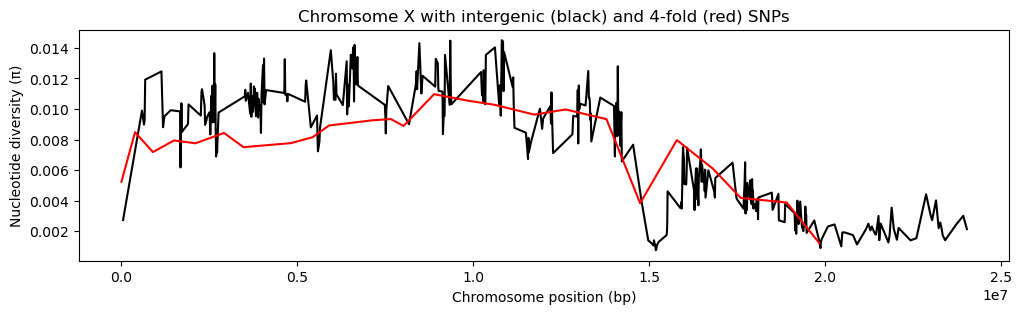

In [25]:
# PLOTTING THE SLIDING WINDOW ANALYSIS

# Plot Chromsome X with intergenic + 4-fold SNPs - using 10,000 loci windows
plt.figure(figsize=(12, 3))
plt.plot(window_X_int, pi_X_int, color='black')
plt.plot(window_X_4, pi_X_4, color='red')
plt.xlabel("Chromosome position (bp)")
plt.ylabel("Nucleotide diversity (\u03C0)")
plt.title("Chromsome X with intergenic (black) and 4-fold (red) SNPs")
plt.show()

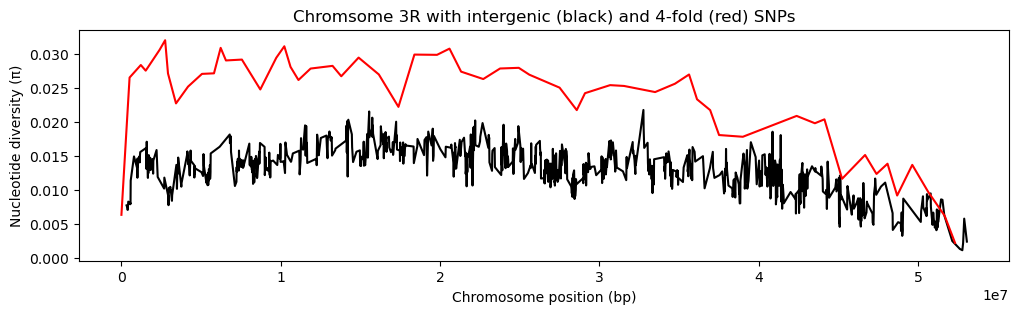

In [27]:
# Plot Chromsome 3R with intergenic + 4-fold SNPs - using 10,000 loci windows

plt.figure(figsize=(12, 3))
plt.plot(window_3R_int, pi_3R_int, color='black')
plt.plot(window_3R_4, pi_3R_4, color='red')
plt.xlabel("Chromosome position (bp)")
plt.ylabel("Nucleotide diversity (\u03C0)")
plt.title("Chromsome 3R with intergenic (black) and 4-fold (red) SNPs")
plt.show()

Drops off after 1.4Mbp for X and 3.5Mbp for 3R. Re-conduct diversity using new chromosome position (or just investigating the heterogenity of diversity across the chromosome). Edit axes etc. after

In [ ]:
# PLOT THE DIVERSITY AND NUMBER OF SNPS IN EACH WINDOW FOR CHROMOSOME 3R

# Create a subplot for the two plots
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot the diversity calculated with intergenic and 4-fold SNPs
#ax1.plot(window_3R_int, pi_3R_int, color='black')
#ax1.plot(window_3R_4, pi_3R_4, color='red')
#ax1.set_ylabel("Nucleotide diversity (\u03C0)")
#ax1.set_title("Chromsome 3R with intergenic (black) and 4-fold (red) SNPs")

# Plot the number of sites in each window
#ax2.plot(window_3R_int, window_size_3R_int, color='black')
#ax2.plot(window_3R_4, window_size_3R_4, color='red')
#ax2.set_xlabel("Chromosome position (bp)")
#ax2.set_ylabel("Number of SNPs")

# Optimise spacing of the plots
#plt.tight_layout()

# View the subplots
#plt.show()

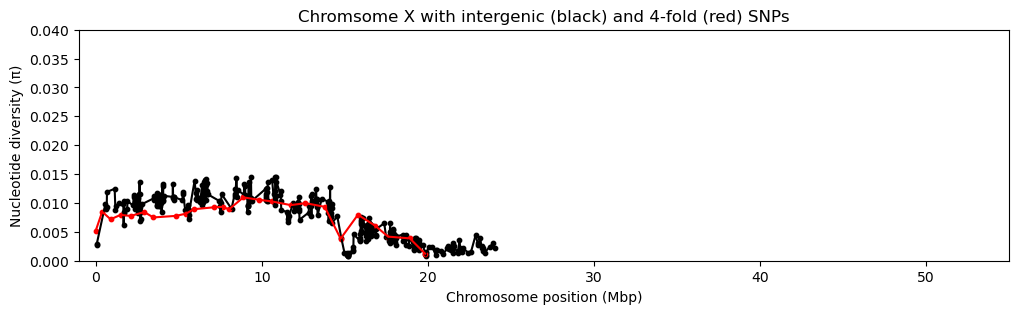

In [28]:
# PLOTTING X AND 3R WITH THE SAME AXES, CHANGE TO MBP AND CHANGE TO FILLED DOTS AND LINE

# Divide the x values by 1,000,000 to get Mbp
window_X_int_mbp = [x / 1000000 for x in window_X_int]
window_X_4_mbp = [x / 1000000 for x in window_X_4]

# Plot Chromsome X 
plt.figure(figsize=(12, 3))

plt.plot(window_X_int_mbp, pi_X_int, color='black')
plt.plot(window_X_4_mbp, pi_X_4, color='red')

plt.scatter(window_X_int_mbp, pi_X_int, color='black', s = 10)
plt.scatter(window_X_4_mbp, pi_X_4, color='red', s = 10)

plt.xlabel("Chromosome position (Mbp)")
plt.ylabel("Nucleotide diversity (\u03C0)")
plt.title("Chromsome X with intergenic (black) and 4-fold (red) SNPs")
plt.xlim(-1, 55)
plt.ylim(0, 0.040)
plt.show()


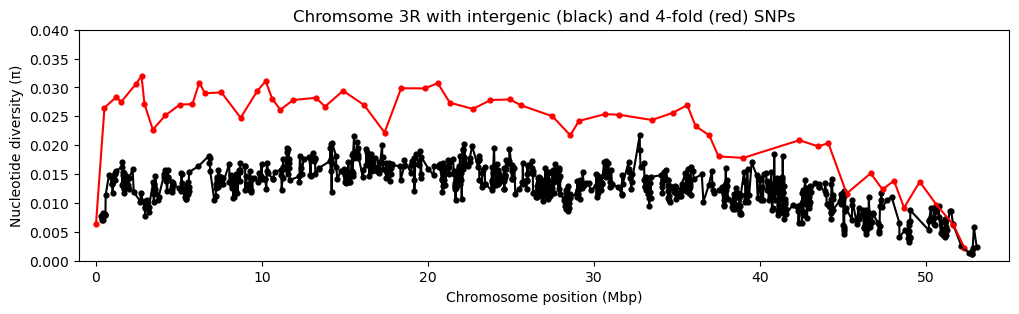

In [29]:
# Divide the x values by 1,000,000 to get Mbp
window_3R_int_mbp = [x / 1000000 for x in window_3R_int]
window_3R_4_mbp = [x / 1000000 for x in window_3R_4]

# Plot 3R
plt.figure(figsize=(12, 3))
plt.scatter(window_3R_int_mbp, pi_3R_int, color='black', s = 12)
plt.scatter(window_3R_4_mbp, pi_3R_4, color='red', s = 12)
plt.plot(window_3R_int_mbp, pi_3R_int, color='black')
plt.plot(window_3R_4_mbp, pi_3R_4, color='red')
plt.xlabel("Chromosome position (Mbp)")
plt.ylabel("Nucleotide diversity (\u03C0)")
plt.title("Chromsome 3R with intergenic (black) and 4-fold (red) SNPs")
plt.xlim(-1, 55)
plt.ylim(0, 0.040)

plt.show()

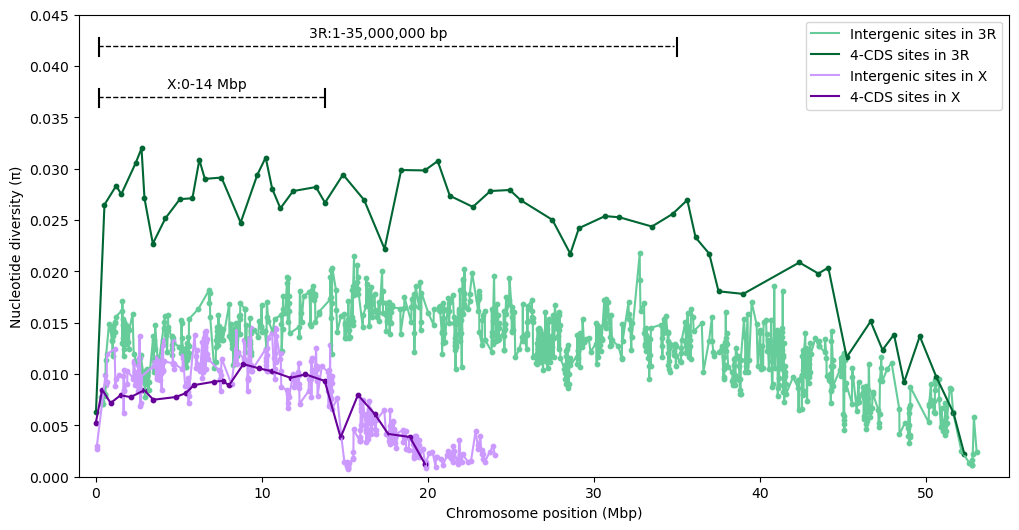

In [30]:
# PLOTTING X AND 3R ON THE SAME PLOT

plt.figure(figsize=(12, 6)) #12,6

plt.scatter(window_3R_int_mbp, pi_3R_int, color='#66CC99', s = 10, ) # Light green
plt.scatter(window_3R_4_mbp, pi_3R_4, color='#006633', s = 10) # Dark green
plt.plot(window_3R_int_mbp, pi_3R_int, color='#66CC99', label='Intergenic sites in 3R')
plt.plot(window_3R_4_mbp, pi_3R_4, color='#006633', label='4-CDS sites in 3R')

plt.plot(window_X_int_mbp, pi_X_int, color='#CC99FF', label='Intergenic sites in X') # Light purple
plt.plot(window_X_4_mbp, pi_X_4, color='#660099', label='4-CDS sites in X') # Dark purple
plt.scatter(window_X_int_mbp, pi_X_int, color='#CC99FF', s = 10) 
plt.scatter(window_X_4_mbp, pi_X_4, color='#660099', s = 10)

plt.xlabel("Chromosome position (Mbp)")
plt.ylabel("Nucleotide diversity (\u03C0)")
#plt.title("Sliding window analysis of nucleotide diversity of chromosome X and 3R")
plt.xlim(-1, 55)
plt.ylim(0, 0.045)

# Add legend
plt.legend()

# Add horizontal and vertical lines to show chromosome positions used in the calculations

# Chromosome X
plt.axhline(y=0.037, xmin=0.02, xmax=0.265, linewidth= 1, color='black', ls = 'dashed')
plt.axvline(x= 0.2, ymin=0.8, ymax=0.84, color = 'black')
plt.axvline(x= 13.8, ymin=0.8, ymax=0.84, color = 'black')
plt.text(6.7, 0.0375 , 'X:0-14 Mbp', ha='center', va='bottom')

# Chromosome 3R
plt.axhline(y=0.042, xmin=0.02, xmax=0.64, linewidth= 1, color='black', ls = 'dashed')
plt.axvline(x= 0.2, ymin=0.91, ymax=0.95, color = 'black')
plt.axvline(x= 35, ymin=0.91, ymax=0.95, color = 'black')
plt.text(17, 0.0425 , '3R:1-35,000,000 bp', ha='center', va='bottom')

# Label centromere and telomere sides
#plt.text(1, 0.0455 , 'Telomere', ha='center', va='bottom')

# Save the figure as png
#plt.savefig('sliding window.png')

plt.show()

In [23]:
# ADDING THE 3R:X THEORETICAL EXPECTATION ON THE SAME PLOT

# Calculating the expected diversity for X

# Calculating 3/4 of the diversity for 3R for the intergenic results
print("Intergenic expected:", format(0.0136*0.75, '.4f'))
print("Intergenic actual: 0.0080 \n")

# Calculating 3/4 of the diversity for 3R for the 4-fold results
print("4-fold expected:", format(0.0240*0.75, '.4f'))
print("4-fold actual: 0.0078")


Intergenic expected: 0.0102
Intergenic actual: 0.0080 

4-fold expected: 0.0180
4-fold actual: 0.0078


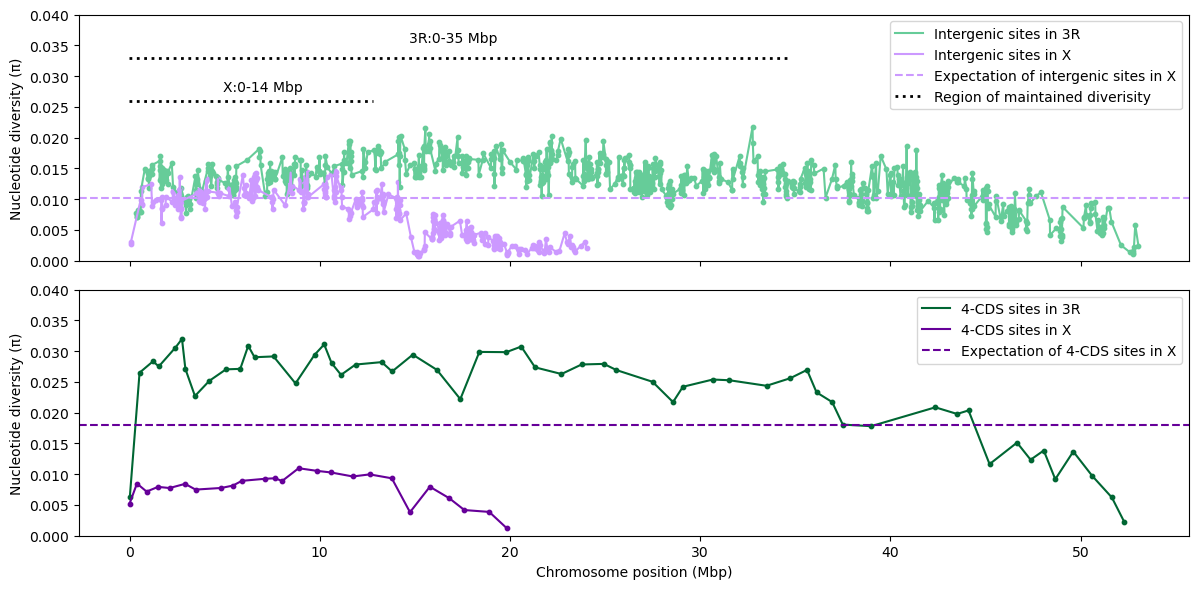

In [31]:
# UPDATED PLOT

# Create a subplot for the two plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey = True) 

# Plot the diversity calculated with intergenic 
ax1.scatter(window_3R_int_mbp, pi_3R_int, color='#66CC99', s = 10, ) # Light green
ax1.plot(window_3R_int_mbp, pi_3R_int, color='#66CC99', label='Intergenic sites in 3R')
ax1.plot(window_X_int_mbp, pi_X_int, color='#CC99FF', label='Intergenic sites in X') # Light purple
ax1.scatter(window_X_int_mbp, pi_X_int, color='#CC99FF', s = 10) 
ax1.set_ylabel("Nucleotide diversity (\u03C0)")

# Plot the diversity calculated with 4-fold 
ax2.scatter(window_3R_4_mbp, pi_3R_4, color='#006633', s = 10) # Dark green
ax2.plot(window_3R_4_mbp, pi_3R_4, color='#006633', label='4-CDS sites in 3R')
ax2.plot(window_X_4_mbp, pi_X_4, color='#660099', label='4-CDS sites in X') # Dark purple
ax2.scatter(window_X_4_mbp, pi_X_4, color='#660099', s = 10)
ax2.set_ylabel("Nucleotide diversity (\u03C0)")
ax2.set_xlabel("Chromosome position (Mbp)")

# Set the y limits
ax1.set_ylim(0, 0.04)

# Label the theoretical expectation of X (0.75 of 3R)
ax1.axhline(y=0.0102, xmin=0, xmax=1, linewidth= 1.5, color='#CC99FF', ls = 'dashed', label='Expectation of intergenic sites in X') # Intergenic expectation of X
ax2.axhline(y=0.0180, xmin=0, xmax=1, linewidth= 1.5, color='#660099', ls = 'dashed',  label='Expectation of 4-CDS sites in X') # 4-fold

# Add horizontal and vertical lines to show chromosome positions used in the calculations

# Chromosome X
ax1.axhline(y=0.026, xmin=0.045, xmax=0.265, linewidth= 2, color='black', ls = 'dotted', label = 'Region of maintained diverisity')
#ax1.axvline(x= 0.2, ymin=0.8, ymax=0.84, color = 'black')
#ax1.axvline(x= 13.8, ymin=0.8, ymax=0.84, color = 'black')
ax1.text(7, 0.027 , 'X:0-14 Mbp', ha='center', va='bottom')

# Chromosome 3R
ax1.axhline(y=0.033, xmin=0.045, xmax=0.64, linewidth= 2, color='black', ls = 'dotted')
#ax1.axvline(x= 0.2, ymin=0.91, ymax=0.95, color = 'black')
#ax1.axvline(x= 35, ymin=0.91, ymax=0.95, color = 'black')
ax1.text(17, 0.035 , '3R:0-35 Mbp', ha='center', va='bottom')

# Add a legend
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

# Optimise spacing of the plots
plt.tight_layout()

# View the subplots
plt.show()

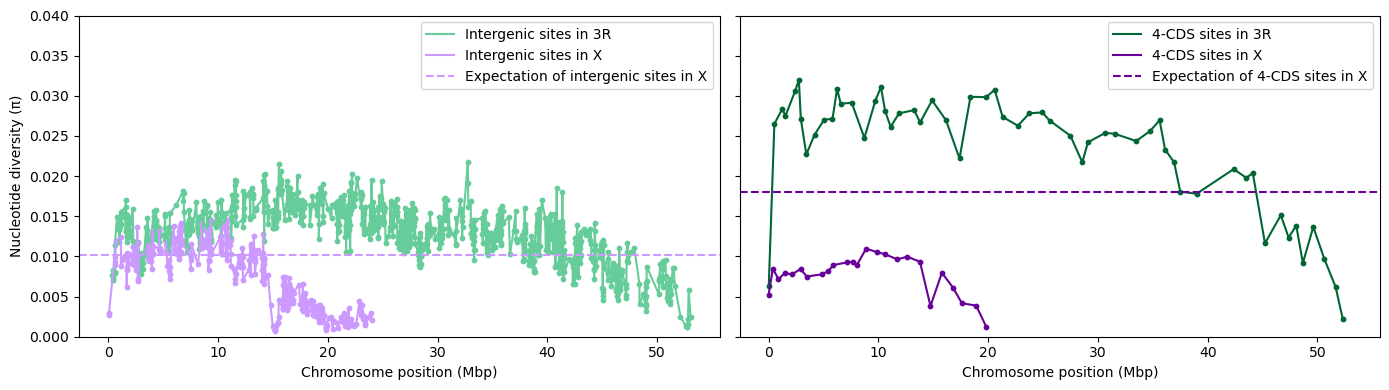

In [32]:
# UPDATED PLOT

# Create a subplot for the two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey = True) 

# Plot the diversity calculated with intergenic 
ax1.scatter(window_3R_int_mbp, pi_3R_int, color='#66CC99', s = 10, ) # Light green
ax1.plot(window_3R_int_mbp, pi_3R_int, color='#66CC99', label='Intergenic sites in 3R')
ax1.plot(window_X_int_mbp, pi_X_int, color='#CC99FF', label='Intergenic sites in X') # Light purple
ax1.scatter(window_X_int_mbp, pi_X_int, color='#CC99FF', s = 10) 
ax1.set_ylabel("Nucleotide diversity (\u03C0)")
ax1.set_xlabel("Chromosome position (Mbp)")

# Plot the diversity calculated with 4-fold 
ax2.scatter(window_3R_4_mbp, pi_3R_4, color='#006633', s = 10) # Dark green
ax2.plot(window_3R_4_mbp, pi_3R_4, color='#006633', label='4-CDS sites in 3R')
ax2.plot(window_X_4_mbp, pi_X_4, color='#660099', label='4-CDS sites in X') # Dark purple
ax2.scatter(window_X_4_mbp, pi_X_4, color='#660099', s = 10)
ax2.set_xlabel("Chromosome position (Mbp)")

# Set the y limits
ax1.set_ylim(0, 0.04)

# Label the theoretical expectation of X (0.75 of 3R)
ax1.axhline(y=0.0102, xmin=0, xmax=1, linewidth= 1.5, color='#CC99FF', ls = 'dashed', label='Expectation of intergenic sites in X') # Intergenic expectation of X
ax2.axhline(y=0.0180, xmin=0, xmax=1, linewidth= 1.5, color='#660099', ls = 'dashed',  label='Expectation of 4-CDS sites in X') # 4-fold



# Add a legend
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

# Optimise spacing of the plots
plt.tight_layout()

# View the subplots
plt.show()

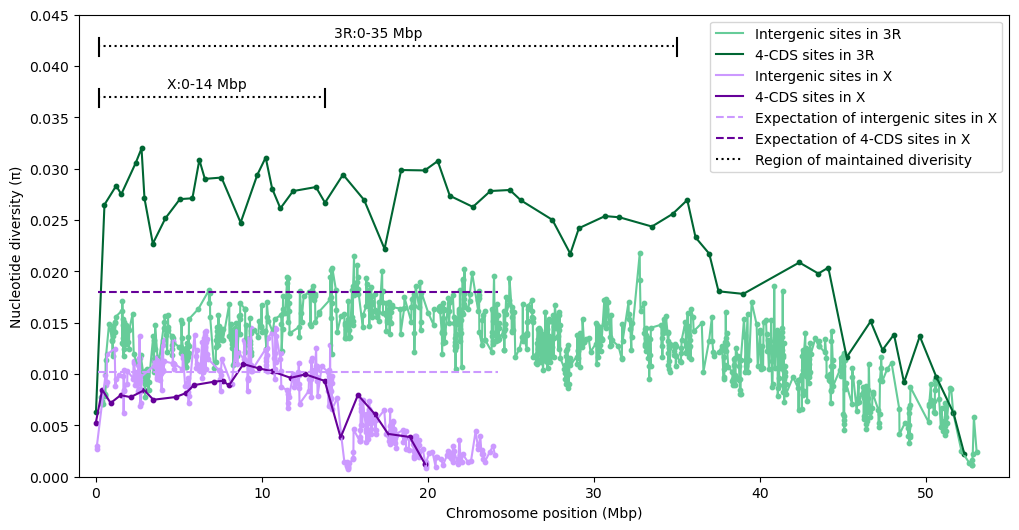

In [56]:
# PLOTTING X AND 3R ON THE SAME PLOT

plt.figure(figsize=(12, 6)) #12,6

plt.scatter(window_3R_int_mbp, pi_3R_int, color='#66CC99', s = 10, ) # Light green
plt.scatter(window_3R_4_mbp, pi_3R_4, color='#006633', s = 10) # Dark green
plt.plot(window_3R_int_mbp, pi_3R_int, color='#66CC99', label='Intergenic sites in 3R')
plt.plot(window_3R_4_mbp, pi_3R_4, color='#006633', label='4-CDS sites in 3R')

plt.plot(window_X_int_mbp, pi_X_int, color='#CC99FF', label='Intergenic sites in X') # Light purple
plt.plot(window_X_4_mbp, pi_X_4, color='#660099', label='4-CDS sites in X') # Dark purple
plt.scatter(window_X_int_mbp, pi_X_int, color='#CC99FF', s = 10) 
plt.scatter(window_X_4_mbp, pi_X_4, color='#660099', s = 10)

plt.xlabel("Chromosome position (Mbp)")
plt.ylabel("Nucleotide diversity (\u03C0)")
#plt.title("Sliding window analysis of nucleotide diversity of chromosome X and 3R")
plt.xlim(-1, 55)
plt.ylim(0, 0.045)


# Label the theoretical expectation
plt.axhline(y=0.0102, xmin=0.02, xmax=0.45, linewidth= 1.5, color='#CC99FF', ls = 'dashed', label='Expectation of intergenic sites in X') # Intergenic expectation of X
plt.axhline(y=0.0180, xmin=0.02, xmax=0.45, linewidth= 1.5, color='#660099', ls = 'dashed',  label='Expectation of 4-CDS sites in X') # 4-fold

# Add horizontal and vertical lines to show chromosome positions used in the calculations

# Chromosome X
plt.axhline(y=0.037, xmin=0.02, xmax=0.265, linewidth= 1.5, color='black', ls = 'dotted')
plt.axvline(x= 0.2, ymin=0.8, ymax=0.84, color = 'black')
plt.axvline(x= 13.8, ymin=0.8, ymax=0.84, color = 'black')
plt.text(6.7, 0.0375 , 'X:0-14 Mbp', ha='center', va='bottom')

# Chromosome 3R
plt.axhline(y=0.042, xmin=0.02, xmax=0.64, linewidth= 1.5, color='black', ls = 'dotted', label = 'Region of maintained diverisity')
plt.axvline(x= 0.2, ymin=0.91, ymax=0.95, color = 'black')
plt.axvline(x= 35, ymin=0.91, ymax=0.95, color = 'black')
plt.text(17, 0.0425 , '3R:0-35 Mbp', ha='center', va='bottom')

# Add legend
plt.legend()

# Save the figure as png
plt.savefig('sliding window.png')

plt.show()

#### FINAL PLOT

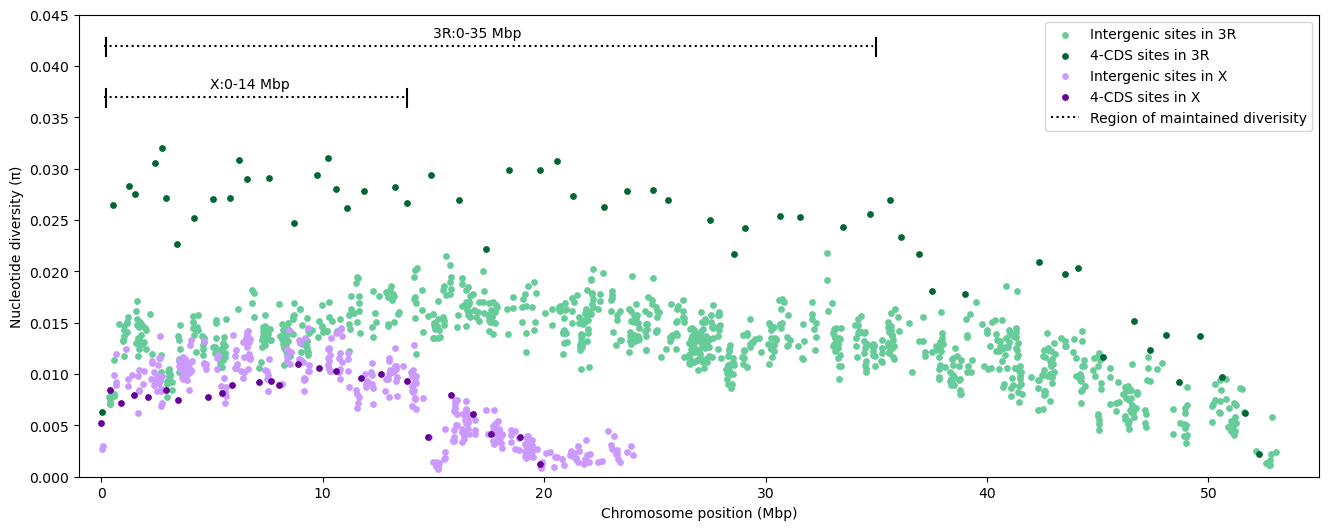

In [89]:
# PLOTTING X AND 3R ON THE SAME PLOT ONLY SCATTER

plt.figure(figsize=(16, 6)) #12,6

plt.scatter(window_3R_int_mbp, pi_3R_int, color='#66CC99', s = 15, label='Intergenic sites in 3R' ) # Light green
plt.scatter(window_3R_4_mbp, pi_3R_4, color='#006633', s = 15, label='4-CDS sites in 3R') # Dark green
#plt.plot(window_3R_int_mbp, pi_3R_int, color='#66CC99', label='Intergenic sites in 3R')
#plt.plot(window_3R_4_mbp, pi_3R_4, color='#006633', label='4-CDS sites in 3R')

#plt.plot(window_X_int_mbp, pi_X_int, color='#CC99FF', label='Intergenic sites in X') # Light purple
#plt.plot(window_X_4_mbp, pi_X_4, color='#660099', label='4-CDS sites in X') # Dark purple
plt.scatter(window_X_int_mbp, pi_X_int, color='#CC99FF', s = 15, label='Intergenic sites in X') 
plt.scatter(window_X_4_mbp, pi_X_4, color='#660099', s = 15, label='4-CDS sites in X')

plt.xlabel("Chromosome position (Mbp)")
plt.ylabel("Nucleotide diversity (\u03C0)")
#plt.title("Sliding window analysis of nucleotide diversity of chromosome X and 3R")
plt.xlim(-1, 55)
plt.ylim(0, 0.045)

# Add horizontal and vertical lines to show chromosome positions used in the calculations

# Chromosome X
plt.axhline(y=0.037, xmin=0.02, xmax=0.265, linewidth= 1.5, color='black', ls = 'dotted')
plt.axvline(x= 0.2, ymin=0.8, ymax=0.84, color = 'black')
plt.axvline(x= 13.8, ymin=0.8, ymax=0.84, color = 'black')
plt.text(6.7, 0.0375 , 'X:0-14 Mbp', ha='center', va='bottom')

# Chromosome 3R
plt.axhline(y=0.042, xmin=0.02, xmax=0.64, linewidth= 1.5, color='black', ls = 'dotted', label = 'Region of maintained diverisity')
plt.axvline(x= 0.2, ymin=0.91, ymax=0.95, color = 'black')
plt.axvline(x= 35, ymin=0.91, ymax=0.95, color = 'black')
plt.text(17, 0.0425 , '3R:0-35 Mbp', ha='center', va='bottom')

# Add a label on the figure for X and 3R?
#plt.text(25, 0.0025, 'Chromosome X', fontsize=12, color='black')
#plt.text(46, 0.02, 'Chromosome 3R', fontsize=12, color='black')

# Add legend
plt.legend()

# Save the figure as png
#plt.savefig('sliding window only points.png')

plt.show()

### 4. Updating the diversity calculations

Re-calculate diversity with the updated chromosome positons (removing areas of low recombination as shown by decrease in diversity in the sliding window analysis).

Sliding window results: Diversity starts to drop after around 3.5e^7 (35 Mbp) for chromosome 3R and 1.4e^7 (14 Mbp) for chromosome X

#### 4.1 Compute diversity statistics

In [ ]:
# RE-COMPUTING DIVERSITY STATISTICS 
# X and intergenic sites

Mali_Niono_dv_stats_X_int_updated = ag3.diversity_stats(
    sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
    sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')",
    cohorts="admin2_year",
    cohort_size=70,
    region="X:1-14000000",
    site_mask="gamb_colu",
    site_class="INTERGENIC",
)

Mali_Niono_dv_stats_X_int_updated

In [ ]:
# RE-COMPUTING DIVERSITY STATISTICS 
# X and 4-fold degenerate sites

Mali_Niono_dv_stats_X_4_updated = ag3.diversity_stats(
    sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
    sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')",
    cohorts="admin2_year",
    cohort_size=70,
    region="X:1-14000000",
    site_mask="gamb_colu",
    site_class="CDS_DEG_4",
)

Mali_Niono_dv_stats_X_4_updated

In [ ]:
# RE-COMPUTING DIVERSITY STATISTICS 
# 3R and intergenic sites

Mali_Niono_dv_stats_3R_int_updated = ag3.diversity_stats(
    sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
    sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')",
    cohorts="admin2_year",
    cohort_size=70,
    region="3R:1-35000000",
    site_mask="gamb_colu",
    site_class="INTERGENIC",
)

Mali_Niono_dv_stats_3R_int_updated

In [ ]:
# RE-COMPUTING DIVERSITY STATISTICS 
# 3R and 4-fold degenerate sites

Mali_Niono_dv_stats_3R_4_updated = ag3.diversity_stats(
    sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
    sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013 or year == 2015) and (location == 'Sokourani (Niono)')",
    cohorts="admin2_year",
    cohort_size=70,
    region="3R:1-35000000",
    site_mask="gamb_colu",
    site_class="CDS_DEG_4",
)

Mali_Niono_dv_stats_3R_4_updated

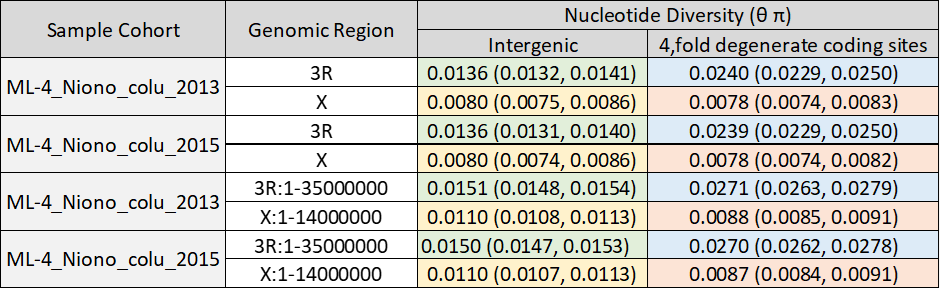

Numbers in parentheses are 95% C.I. which was calculated using block jackknife.

#### 4.2 Calculating the number of sites

Available in the .ipynb file called: FYP - (2.1) Diversity number of sites

### 5. Historical Ne estimation

Uses the equation 𝑁𝑒= 𝜋/(4 × 𝜇)

Mutation rate (𝜇) (per base pair per generation) of 2.8 × 10^-9 will be used (calculated from Drosophila melanogaster) - https://pubmed.ncbi.nlm.nih.gov/24214343/ and in https://academic.oup.com/mbe/article/36/9/2040/5435963?login=true

In [2]:
# CALCULATE NE 

print("2013_3R_int:", format(0.0136/(4*2.8e-9) ,'.0f'))
print("2013_3R_int:", format(0.0132/(4*2.8e-9) ,'.0f'))
print("2013_3R_int:", format(0.0141/(4*2.8e-9) ,'.0f'))

print("\n2013_3R_4:", format(0.0240/(4*2.8e-9) ,'.0f'))
print("2013_3R_4:", format(0.0229/(4*2.8e-9) ,'.0f'))
print("2013_3R_4:", format(0.0250/(4*2.8e-9) ,'.0f'))

print("\n2013_X_int:", format(0.0080/(4*2.8e-9) ,'.0f'))
print("2013_X_int:", format(0.0075/(4*2.8e-9) ,'.0f'))
print("2013_X_int:", format(0.0086/(4*2.8e-9) ,'.0f'))

print("\n2013_X_4:", format(0.0078/(4*2.8e-9) ,'.0f'))
print("2013_X_4:", format(0.0074/(4*2.8e-9) ,'.0f'))
print("2013_X_4:", format(0.0083/(4*2.8e-9) ,'.0f'))

print("\n2015_3R_int:", format(0.0136/(4*2.8e-9) ,'.0f'))
print("2015_3R_int:", format(0.0131/(4*2.8e-9) ,'.0f'))
print("2015_3R_int:", format(0.0140/(4*2.8e-9) ,'.0f'))

print("\n2015_3R_4:", format(0.0239/(4*2.8e-9) ,'.0f'))
print("2015_3R_4:", format(0.0229/(4*2.8e-9) ,'.0f'))
print("2015_3R_4:", format(0.0250/(4*2.8e-9) ,'.0f'))

print("\n2015_X_int:", format(0.0080/(4*2.8e-9) ,'.0f'))
print("2015_X_int:", format(0.0074/(4*2.8e-9) ,'.0f'))
print("2015_X_int:", format(0.0086/(4*2.8e-9) ,'.0f'))

print("\n2015_X_4:", format(0.0078/(4*2.8e-9) ,'.0f'))
print("2015_X_4:", format(0.0074/(4*2.8e-9) ,'.0f'))
print("2015_X_4:", format(0.0082/(4*2.8e-9) ,'.0f'))


#print("\n2013_new_3R_int:", format(0.0136/(4*2.8e-9) ,'.0f'))
#print("2013_new_3R_int:", format(0.0132/(4*2.8e-9) ,'.0f'))
#print("2013_new_3R_int:", format(0.0141/(4*2.8e-9) ,'.0f'))

2013_3R_int: 1214286
2013_3R_int: 1178571
2013_3R_int: 1258929

2013_3R_4: 2142857
2013_3R_4: 2044643
2013_3R_4: 2232143

2013_X_int: 714286
2013_X_int: 669643
2013_X_int: 767857

2013_X_4: 696429
2013_X_4: 660714
2013_X_4: 741071

2015_3R_int: 1214286
2015_3R_int: 1169643
2015_3R_int: 1250000

2015_3R_4: 2133929
2015_3R_4: 2044643
2015_3R_4: 2232143

2015_X_int: 714286
2015_X_int: 660714
2015_X_int: 767857

2015_X_4: 696429
2015_X_4: 660714
2015_X_4: 732143


In [3]:
# NEW CHROMOSOME POSITIONS

print("2013_3R_int_new:", format(0.0151/(4*2.8e-9) ,'.0f'))
print("2013_3R_int_new:", format(0.0148/(4*2.8e-9) ,'.0f'))
print("2013_3R_int_new:", format(0.0154/(4*2.8e-9) ,'.0f'))

print("\n2013_3R_4_new:", format(0.0271/(4*2.8e-9) ,'.0f'))
print("2013_3R_4_new:", format(0.0263/(4*2.8e-9) ,'.0f'))
print("2013_3R_4_new:", format(0.0279/(4*2.8e-9) ,'.0f'))

print("\n2013_X_int_new:", format(0.0110/(4*2.8e-9) ,'.0f'))
print("2013_X_int_new:", format(0.0108/(4*2.8e-9) ,'.0f'))
print("2013_X_int_new:", format(0.0113/(4*2.8e-9) ,'.0f'))

print("\n2013_X_4_new:", format(0.0088/(4*2.8e-9) ,'.0f'))
print("2013_X_4_new:", format(0.0085/(4*2.8e-9) ,'.0f'))
print("2013_X_4_new:", format(0.0091/(4*2.8e-9) ,'.0f'))

print("\n2015_3R_int_new:", format(0.0150/(4*2.8e-9) ,'.0f'))
print("2015_3R_int_new:", format(0.0147/(4*2.8e-9) ,'.0f'))
print("2015_3R_int_new:", format(0.0153/(4*2.8e-9) ,'.0f'))

print("\n2015_3R_4_new:", format(0.0270/(4*2.8e-9) ,'.0f'))
print("2015_3R_4_new:", format(0.0262/(4*2.8e-9) ,'.0f'))
print("2015_3R_4_new:", format(0.0278/(4*2.8e-9) ,'.0f'))

print("\n2015_X_int_new:", format(0.0110/(4*2.8e-9) ,'.0f'))
print("2015_X_int_new:", format(0.0107/(4*2.8e-9) ,'.0f'))
print("2015_X_int_new:", format(0.0113/(4*2.8e-9) ,'.0f'))

print("\n2015_X_4_new:", format(0.0087/(4*2.8e-9) ,'.0f'))
print("2015_X_4_new:", format(0.0084/(4*2.8e-9) ,'.0f'))
print("2015_X_4_new:", format(0.0091/(4*2.8e-9) ,'.0f'))


2013_3R_int_new: 1348214
2013_3R_int_new: 1321429
2013_3R_int_new: 1375000

2013_3R_4_new: 2419643
2013_3R_4_new: 2348214
2013_3R_4_new: 2491071

2013_X_int_new: 982143
2013_X_int_new: 964286
2013_X_int_new: 1008929

2013_X_4_new: 785714
2013_X_4_new: 758929
2013_X_4_new: 812500

2015_3R_int_new: 1339286
2015_3R_int_new: 1312500
2015_3R_int_new: 1366071

2015_3R_4_new: 2410714
2015_3R_4_new: 2339286
2015_3R_4_new: 2482143

2015_X_int_new: 982143
2015_X_int_new: 955357
2015_X_int_new: 1008929

2015_X_4_new: 776786
2015_X_4_new: 750000
2015_X_4_new: 812500
